In [1]:
import requests
import os
from sodapy import Socrata
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np

In [2]:
socrata_domain = "data.cityofnewyork.us"
s_token= "owhOVQVkxAIoOnckQs4UrHcVo"
client = Socrata(socrata_domain, s_token)
results=client.get("uvbq-3m68",limit=100,where="issue_date like'%/2018'")

In [3]:
results_df=pd.DataFrame.from_records(results)


In [4]:
results_df["payment_amount"]=results_df.payment_amount.apply(pd.to_numeric)
results_df["reduction_amount"]=results_df.reduction_amount.apply(pd.to_numeric)
results_df["amount_due"]=results_df.amount_due.apply(pd.to_numeric)
results_df["fine_amount"]=results_df.fine_amount.apply(pd.to_numeric)
results_df["interest_amount"]=results_df.interest_amount.apply(pd.to_numeric)
results_df["penalty_amount"]=results_df.penalty_amount.apply(pd.to_numeric)

In [5]:
df_precinct=results_df.groupby(["precinct"])["summons_number"].count()
results_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 19 columns):
amount_due             100 non-null float64
county                 100 non-null object
fine_amount            100 non-null int64
interest_amount        100 non-null float64
issue_date             100 non-null object
issuing_agency         100 non-null object
judgment_entry_date    11 non-null object
license_type           100 non-null object
payment_amount         100 non-null float64
penalty_amount         100 non-null int64
plate                  100 non-null object
precinct               100 non-null object
reduction_amount       100 non-null float64
state                  100 non-null object
summons_image          100 non-null object
summons_number         100 non-null object
violation              100 non-null object
violation_status       31 non-null object
violation_time         100 non-null object
dtypes: float64(4), int64(2), object(13)
memory usage: 14.9+ KB


In [17]:
coord=pd.read_excel("Coord_Precinct.xlsx",converters={"Code":str})
coord=coord.rename(columns={"Code":"precinct"})
coord.tail()

FileNotFoundError: [Errno 2] No such file or directory: 'Coord_Precinct.xlsx'

In [ ]:
df_Pr=pd.merge(results_df,coord,on="precinct")

In [ ]:
dfCount=df_Pr.groupby(["precinct"])["summons_number"].count()


In [7]:
Coordinate=pd.merge(coord,dfCount,on="precinct")

NameError: name 'coord' is not defined

In [8]:
Coordinate

NameError: name 'Coordinate' is not defined

In [9]:
plt.figure(figsize=(15,12))
plt.scatter(x=Coordinate["lon"], y=Coordinate["Lat"], s=Coordinate["summons_number"]*0.09,
            alpha=0.7)

NameError: name 'Coordinate' is not defined

<Figure size 1080x864 with 0 Axes>

In [10]:
date_list = []
month_list = []
time_list = []
hours_list = []
year_int = 0
month_int = 0
day_int = 0
total_violations = len(results_df)

In [11]:
violation_time_df = results_df["violation_time"]
for time in violation_time_df:
    try:
        if time[-1:] == "A" or int(time[:2]) == 12:
            try:
                hours_int = int(time[:2])
                minutes_int = int(time[3:5])
                issue_time = datetime.time(hours_int, minutes_int)
            except (ValueError):
                print(time)
        elif time[-1:] == "P" and int(time[:2]) != 12:
            try:
                hours_int = int(time[:2]) + 12
                minutes_int = int(time[3:5])
                issue_time = datetime.time(hours_int, minutes_int)
            except (ValueError):
                print(time)
    except (TypeError):
        hours_int = np.NaN
        minutes_int = np.NaN
        issue_time = np.NaN

        
    time_list.append(issue_time)
    hours_list.append(hours_int)
##################################################################
issue_date_df = results_df["issue_date"]
for date in issue_date_df:
    try:
        year_int = int(date[-4:])
        month_int = int(date[:2])
        day_int = int(date[3:5])
        ymd = datetime.datetime(year_int, month_int, day_int)
        date_list.append(ymd)
        month_list.append(month_int)
    except (ValueError):
        year_int = np.NaN
        month_int = np.NaN
        day_int = np.NaN
        ymd = np.NaN
        date_list.append(ymd)
        month_list.append(month_int)    

In [12]:
results_df["Date Issued"] = date_list
results_df["Month Issued"] = month_list
results_df["Time Issued"] = time_list
results_df["Hour Issued"] = hours_list

In [13]:
date_grouped_df = results_df.groupby(["Month Issued"]).count()
plt.bar(date_offense_count_df.index, date_offense_count_df["plate"], color="b", align="center")
plt.title("Violations vs. Month of Year")
plt.xlabel("Month")
plt.ylabel("Violations")
plt.savefig("violations_vs_month.png")

NameError: name 'date_offense_count_df' is not defined

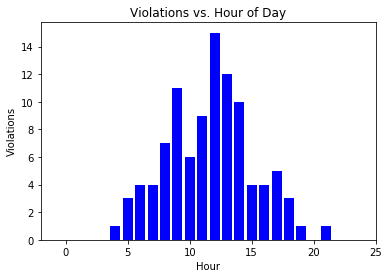

In [14]:
hour_grouped_df = results_df.groupby(["Hour Issued"]).count()
hour_grouped_df.head()
plt.bar(hour_grouped_df.index, hour_grouped_df["plate"], color="b", align="center")
plt.xlim(-2, 25)
plt.title("Violations vs. Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Violations")
plt.savefig("violations_vs_hour.png")

In [15]:
violation_grouped_df = results_df.groupby(["violation"])
violation_count_df = violation_grouped_df.count()

#store total fine $ in variable
fine_sum = violation_grouped_df["fine_amount"].sum()


#reduce dataframe to needed columns
violation_count_reduced = pd.DataFrame(violation_grouped_df["issue_date"])
#violation_count_reduced


In [16]:

#reduce dataframe to needed columns
violation_count_reduced = pd.DataFrame(violation_grouped_df["issue_date"])

#rename column to represent total row count which is also total violation count
violation_count_renamed = violation_count_reduced.rename(columns={"issue_date": "Total Count"})

#calculate violation type occurrences as a percentage of total violations
percent_of_violations = (violation_count_renamed["Total Count"]/total_violations)*100

#add percentage of violations in new column
violation_count_renamed["Percent of Total Count"] = percent_of_violations

#add column for total fine
violation_count_renamed["fine_amount"] = fine_sum

#calculate percent of fines
percent_of_fine = round((violation_count_renamed["fine_amount"]/sum(results_df["fine_amount"]))*100,2)
violation_count_renamed["Percent of Fine"] = percent_of_fine


violation_count_sorted = violation_count_renamed.sort_values("Total Count", ascending=False)
violation_count_sorted.head()

KeyError: 'Total Count'

In [22]:
#JESUS BAQUIAX SECTION

JB_df = results_df[["plate", "amount_due", 
                             "fine_amount", "interest_amount", 
                             "payment_amount", "penalty_amount",
                             "summons_number", "state"]]

plate_grouping = JB_df.groupby(["plate"])

In [24]:
summons_number_count = plate_grouping["summons_number"].count()
summons_number_count.head()

plate
070QXD     1
107TJA     1
203819     1
24034JW    1
2630919    1
Name: summons_number, dtype: int64

In [25]:
fine_amount_count = plate_grouping["fine_amount"].sum()
fine_amount_count.head()

plate
070QXD     115
107TJA      45
203819     115
24034JW     65
2630919     65
Name: fine_amount, dtype: int64

In [26]:
frequency_violation_df = pd.DataFrame({"Total Violation Cost": fine_amount_count, "Frequency": summons_number_count })
frequency_sorted = frequency_violation_df.sort_values("Frequency", ascending=False)
frequency_sorted.head()

,Total Violation Cost,Frequency
plate,,
AMER1C4,180,2
GRA4519,90,2
070QXD,115,1
HNV7178,65,1
HTA3672,35,1


In [27]:
total_violation_cost_sorted = frequency_violation_df.sort_values("Total Violation Cost", ascending=False)
total_violation_cost_sorted.head()

,Total Violation Cost,Frequency
plate,,
AMER1C4,180,2
070QXD,115,1
69198MG,115,1
87615PA,115,1
95523MJ,115,1


In [28]:
bins = [0,2,250]
groups = ["Up to 2 Tickets", "More than 2 tickets"]

frequency_sorted["breakdown"] = pd.cut(frequency_sorted["Frequency"], bins, labels=groups)
frequency_sorted.head()

,Total Violation Cost,Frequency,breakdown
plate,,,
AMER1C4,180,2,Up to 2 Tickets
GRA4519,90,2,Up to 2 Tickets
070QXD,115,1,Up to 2 Tickets
HNV7178,65,1,Up to 2 Tickets
HTA3672,35,1,Up to 2 Tickets


In [29]:
breakdown_variable = frequency_sorted["breakdown"].value_counts()
breakdown_variable

Up to 2 Tickets        98
More than 2 tickets     0
Name: breakdown, dtype: int64

In [30]:
groupedby_breakdown = frequency_sorted.groupby(["breakdown"])
violation_sum = groupedby_breakdown["Total Violation Cost"].sum()
violation_sum

breakdown
Up to 2 Tickets        6830
More than 2 tickets       0
Name: Total Violation Cost, dtype: int64

In [31]:
df_for_graph = pd.DataFrame({"Total $ Generated": violation_sum})
df_for_graph.head()

,Total $ Generated
breakdown,
Up to 2 Tickets,6830
More than 2 tickets,0


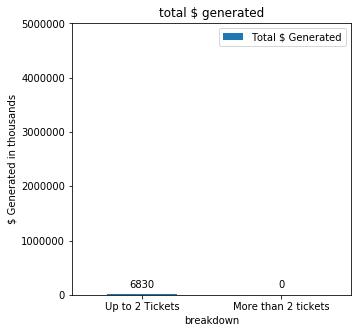

In [32]:
ax = df_for_graph.plot(kind="bar", figsize=(5,5), rot=0)
                  
plt.title("total $ generated")

plt.ylabel("$ Generated in thousands")

for p in ax.patches: 
    ax.annotate(np.round(p.get_height(),decimals=2), (p.get_x()+p.get_width()/2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
    
plt.ylim(0, max(df_for_graph["Total $ Generated"])+ 5000000)

plt.show()

Text(0, 0.5, '')

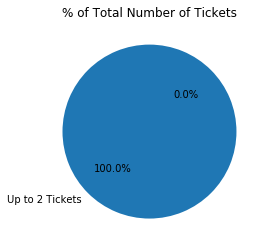

In [33]:
#pie chart

pie = breakdown_variable.plot(kind="pie", title="% of Total Number of Tickets", autopct="%1.1f%%", startangle=45)
pie.set_ylabel("")

Text(0, 0.5, '')

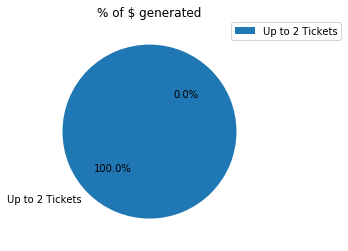

In [34]:
pie2 = violation_sum.plot(kind="pie", title="% of $ generated", autopct="%1.1f%%", startangle=45)
plt.legend(loc="upper left", bbox_to_anchor=(0.85,1.025))
pie2.set_ylabel("")

In [36]:
state_df = results_df[["state", "amount_due", 
                             "fine_amount", "interest_amount", 
                             "payment_amount", "penalty_amount", "summons_number"]]

state_df["Label"] = np.where(state_df["state"]=="NY","NY","Out of State")


state_grouping = state_df.groupby(["Label"])
state_grouping.head()

C:\Users\jesus.baquiax\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,state,amount_due,fine_amount,interest_amount,payment_amount,penalty_amount,summons_number,Label
0,NY,0.0,35,0.0,35.0,0,8638150854,NY
1,PA,0.0,45,0.0,45.0,0,8653965816,Out of State
2,NC,0.0,115,0.0,115.0,0,8627270752,Out of State
3,NY,0.0,45,0.0,45.0,0,8665735215,NY
4,NY,0.0,65,0.0,65.0,0,8670614765,NY
5,NY,0.0,45,0.0,45.0,0,8638150878,NY
6,OK,0.0,45,0.0,45.0,0,8638150970,Out of State
7,MI,0.0,115,0.0,115.0,0,8627270740,Out of State
8,NY,0.0,115,0.0,105.0,0,8627271070,NY
9,NJ,0.0,60,0.0,70.0,10,8648645967,Out of State


In [37]:
fine_amount_sum = state_grouping["fine_amount"].sum()
fine_amount_sum.head()

Label
NY              5100
Out of State    1730
Name: fine_amount, dtype: int64

In [38]:
state_frequency = state_grouping["summons_number"].count()
state_frequency.head()

Label
NY              78
Out of State    22
Name: summons_number, dtype: int64

In [39]:
state_combined_df = pd.DataFrame({"Total Violation Cost": fine_amount_sum, "Frequency": state_frequency})

state_fine_sort = state_combined_df.sort_values("Total Violation Cost", ascending=False)
state_fine_sort.head()

,Total Violation Cost,Frequency
Label,,
NY,5100,78
Out of State,1730,22


In [40]:
state_frequency_sort = state_combined_df.sort_values("Frequency", ascending=False)
state_frequency_sort.head()

,Total Violation Cost,Frequency
Label,,
NY,5100,78
Out of State,1730,22


Text(0, 0.5, '')

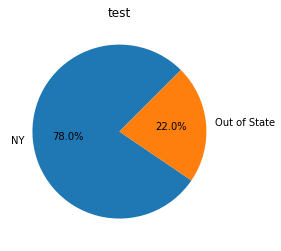

In [41]:
pie3 = state_frequency.plot(kind="pie", title="test", autopct="%1.1f%%", startangle=45)
pie3.set_ylabel("")

In [ ]:
pie4 = fine_amount_sum.plot(kind="pie", title="test", autopct="%1.1f%%", startangle=45)
pie4.set_ylabel("")